# Principal component analysis for multi-spectral data

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction.
It can be used to explore patterns in high-dimensional data and assist unsupervised learning.

Principal components are a series of linear combinations of the original variables, among which the first principal component accounts for the greatest variance within a dataset.
Each subsequent principal component accounts for the next greatest possible variance and is uncorrelated with the previously defined components.

This technique is useful for understanding Sentinel-2 data as images are captured in 12 spectral bands but only 3 variables can be visualized in a RGB composite.
PCA can also be applied to timeseries data to investigate temporal evolution patterns for different land cover types.

## Description

This notebook demonstrates a principal component analysis for Sentinel-2 multi-spectal data. 
Following steps are covered:

1. Loading Sentinel-2 multi-spectral data.
2. Applying PCA to transform and visualize data.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

from sklearn.decomposition import PCA
import datacube
import geopandas as gpd
from datacube.utils.geometry import Geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

Connect to the datacube so we can access DEAfrica data.

In [2]:
dc = datacube.Datacube(app='pca')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `6.502`).
* `lon`: The central longitude to analyse (e.g. `-1.409`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time`: The date range to analyse (e.g. `("2017-08-01", "2019-11-01")`).
For reasonable loading times, make sure the range spans less than 3 years.
* Acceptable range of cloud cover percentage for input Sentinel-2 granule (`min_gooddata`)
* Spectral bands to be explored

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default location is Betsiboka Estuary, Madagascar.


In [3]:
# Set the area of interest
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=-15.92, lon=46.35, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

query = {
    'time': ('2020-01', '2020-03'),
    'x': lon_range,
    'y': lat_range,
    'output_crs': 'epsg:6933',
    'resolution':(-20,20),
}

# use all non-overlapping 10m and 20m bands
bands = ['blue', 'green', 'red', 'red_edge_1', 'red_edge_2',
         'red_edge_3', 'nir_narrow', 'swir_1', 'swir_2']

## Loading Sentinel-2 multi-spectral data

Only high probablity cloud is excluded in this example, but this can be modified for a different area.


In [4]:
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              min_gooddata=0.98,
              group_by='solar_day',
              **query)


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 4 out of 18 time steps with at least 98.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


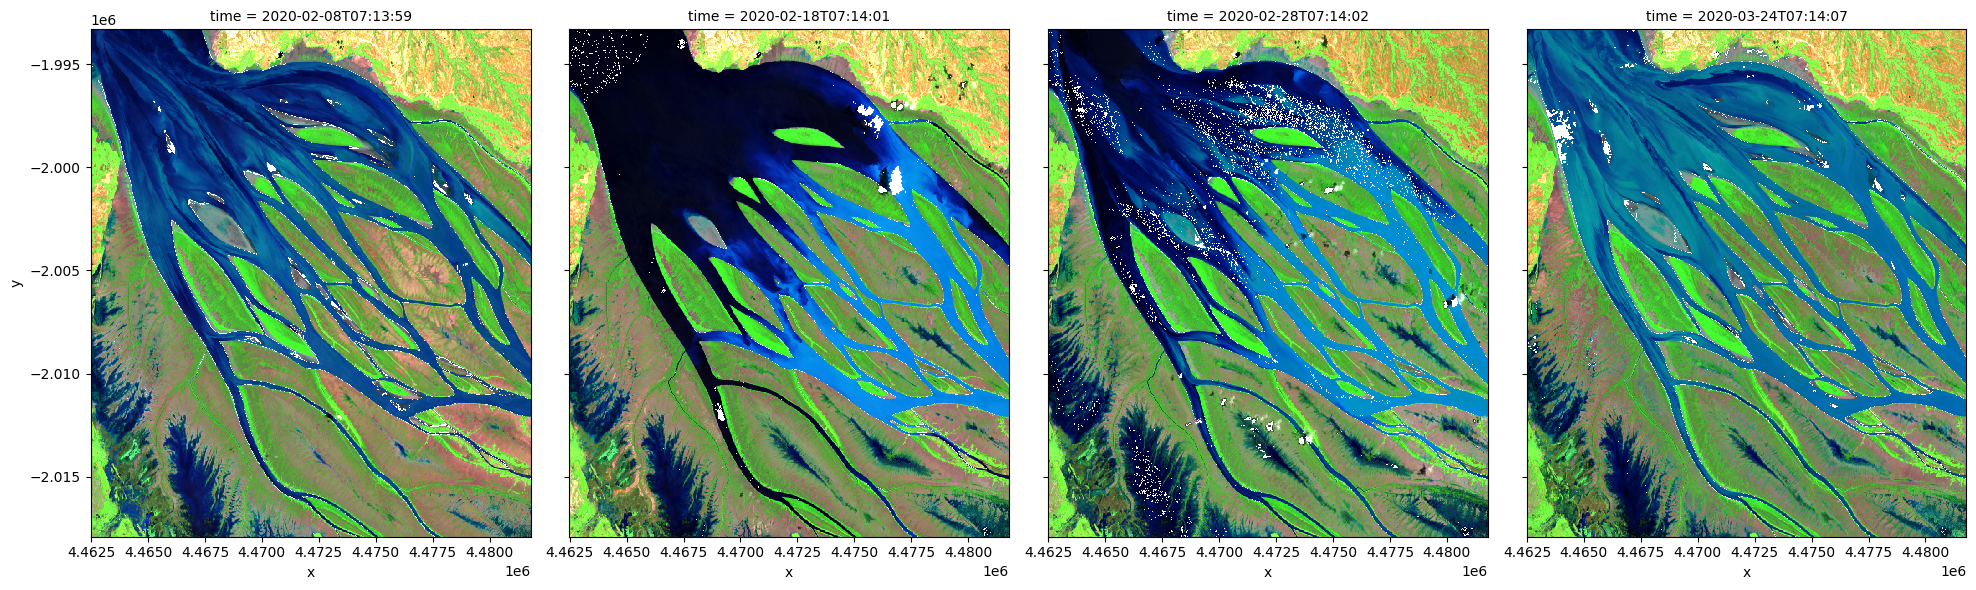

In [5]:
# visualize data using selected input spectral bands
rgb(ds, bands=['swir_1','nir_narrow','red_edge_1'], index=list(range(len(ds.time))), col_wrap=4)

## Applying PCA to transform and visualize data

To perform a PCA, data is first transformed into a numpy array that can be used by sklearn.

In [6]:
X = sklearn_flatten(ds)

A PCA model is generated with 3 principal components and fitted on the data.

In [7]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

We can investigate how much variance is accounted for in each principal component.
In the default example, the first principal component accounts for a much high variance than the next two.

This step can help determine whether more principal components are needed.

In [8]:
print("Relative variance in principal components:", pca.explained_variance_ratio_)

Relative variance in principal components: [0.62940549 0.21629087 0.14767287]


The input data can now be transformed into this new reference space and rearranged into a xarray dataset compatible with input data.

In [9]:
predict = pca.transform(X)

In [10]:
out = sklearn_unflatten(predict, ds)
out = out.to_dataset(dim=out.dims[0]).transpose('time','y','x')

### Visualise PCA results

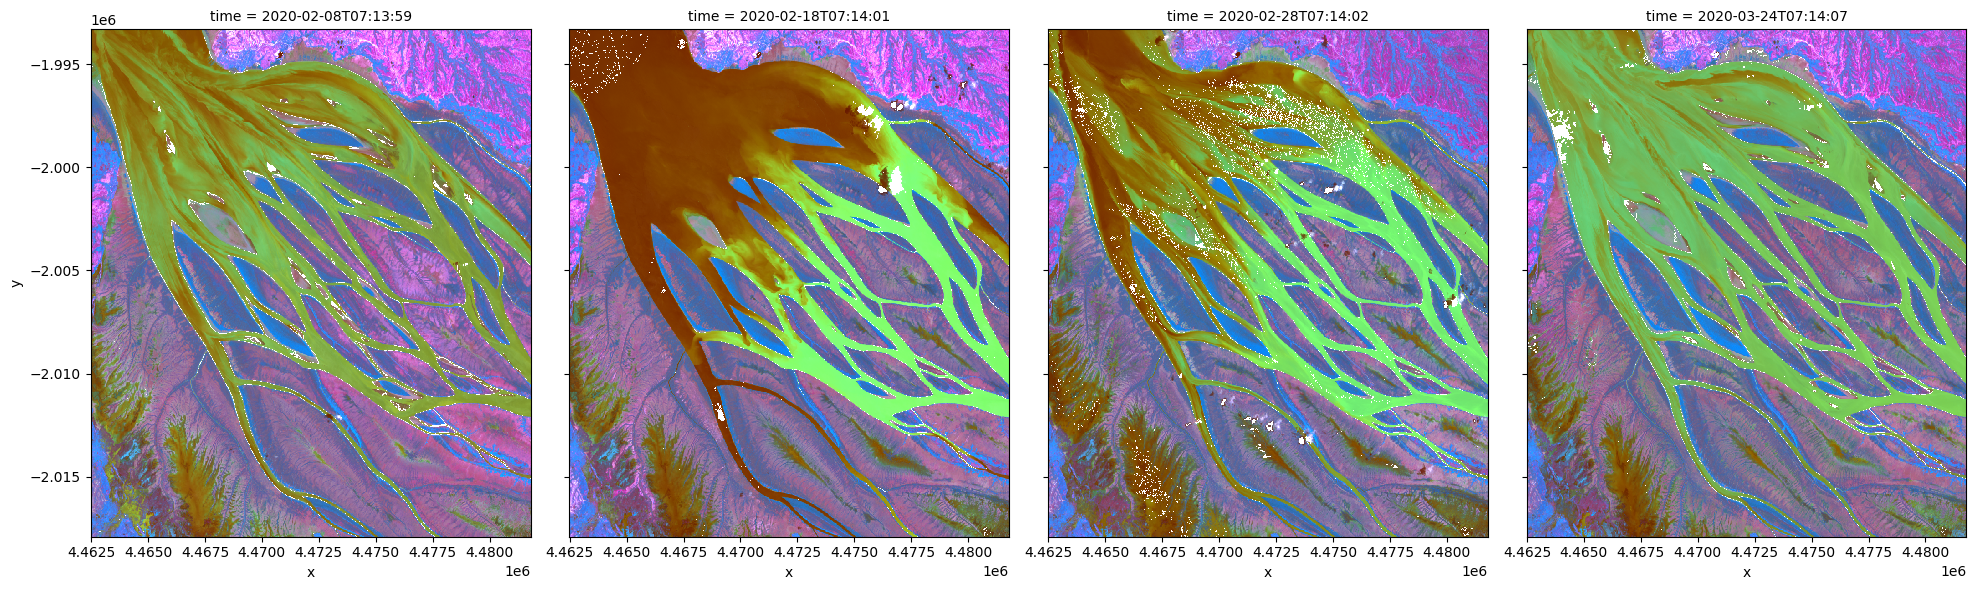

In [11]:
rgb(out, bands=[2,1,0], index=list(range(len(out.time))), col_wrap=4)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-08-14'